# Case Study 3: Detecting Generator Usage from Sensor Data 

# Problem Statement

Many hospitals in sub-Saharan Africa rely on multiple power sources — typically grid electricity, generators, and solar. However, identifying which source is active at any given time is not straightforward. 

The goal of this project is to **detect the active power source** (grid, solar, or generator) at each time window using sensor data that includes voltage and frequency readings taken every 2 minutes. 

We have access to:
- The current rule-based classification of power source usage (used as a reference or "ground truth")
- Raw time-series voltage and frequency data collected by sensors installed in hospital rooms
- Known power source configurations per room



## 1. DATA CLEANING AND WRANGLING


Before we can analyze or model the data, we need to make sure it is **clean, consistent, and structured** properly. This process is known as **data cleaning and wrangling**.

In this section, we will:
- **Inspect the dataset** to understand its structure and contents
- **Handle missing values**, duplicates, or invalid entries
- **Fix data types** (e.g., make sure timestamps are datetime objects)
- **Rename or standardize column names** for clarity
- **Filter out irrelevant data** or focus on key subsets (e.g., only rooms with complete power source info)

The goal is to make the dataset **analysis-ready** so we can confidently explore patterns and relationships in the next step (EDA).


### Inspecting the dataset

In [1]:
import pandas as pd

In [130]:
df=pd.read_csv("sierra-leone_power_source_2023-2024.csv")

/var/folders/z2/qn6brxnj2hq86_bnc891ljkw0000gn/T/ipykernel_8882/2392275839.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("sierra-leone_power_source_2023-2024.csv")


In [3]:
df.head(5)

,time,respondent_id,room,hospital,voltage,frequency,power_source,power_source_est
0,2023-07-22 20:42:03,BBFDA35A,Main drug store - Solar w/Grid Backup,hastings,221.357850,99.940036,Solar w/Grid Backup,unknown
1,2023-07-23 06:58:03,BBFDA35A,Main drug store - Solar w/Grid Backup,hastings,221.357850,99.790440,Solar w/Grid Backup,unknown
2,2023-07-23 13:46:03,BBFDA35A,Main drug store - Solar w/Grid Backup,hastings,221.357850,99.920064,Solar w/Grid Backup,unknown
3,2023-07-23 23:34:03,BBFDA35A,Main drug store - Solar w/Grid Backup,hastings,217.114569,49.957536,Solar w/Grid Backup,solar
4,2023-07-24 00:18:03,BBFDA35A,Main drug store - Solar w/Grid Backup,hastings,219.943423,50.017506,Solar w/Grid Backup,solar


In [4]:
df.columns

Index(['time', 'respondent_id', 'room', 'hospital', 'voltage', 'frequency',
       'power_source', 'power_source_est'],
      dtype='object')

## Column Descriptions

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `time`              | Timestamp when the reading was recorded (every 2 minutes)                   |
| `respondent_id`     | Unique identifier for the sensor or room being monitored                    |
| `room`              | Name or type of room, includes info about its power configuration           |
| `hospital`          | Name of the hospital where the sensor is located                            |
| `voltage`           | Voltage reading captured by the sensor                                      |
| `frequency`         | Frequency reading captured by the sensor                                    |
| `power_source`      | Known power configuration for the room (e.g., "Solar w/Grid Backup")        |
| `power_source_est`  | Estimated active power source detected by the current rule-based algorithm  |


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982001 entries, 0 to 7982000
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   respondent_id     object 
 2   room              object 
 3   hospital          object 
 4   voltage           float64
 5   frequency         float64
 6   power_source      object 
 7   power_source_est  object 
dtypes: float64(2), object(6)
memory usage: 487.2+ MB


In [6]:
df['hospital'].value_counts()

hospital
princess_christian    1579080
ola_during            1250320
masanga                936438
kambia                 800885
kabala                 576153
wilberforce            563562
connaught              504474
bonthe                 439828
hastings               413253
king_harman_road       331501
magburaka              298222
makeni                 288285
Name: count, dtype: int64

In [ ]:
df['respondent_id'].unique()

array(['BBFDA35A', '76B32C6A', 'CD9B9362', '36291A37', '3393AD1E',
       '7A696BB0', '880B12A1', 'AE9D9E66', 'A45DEF14', 'BC894308',
       '19906B6E', '11FE9C82', 'CA7A6C34', 'DF4F22FC', 'E8434F58',
       '95E7399D', '274B46C5', '41570E47', '358F181D', '904166BE',
       '10DA907C', '31581AC3', 'E76A2F18', '285A769C', '9F7BB66B',
       'F818DD2C', 'A7081050', 'B391847B', '10EB0F63', '0BB96209',
       'E3670099', '31AA625C', '1F697CD8', '311723D1', '74901A6B',
       '40101E61', 4.0101e+65, '23D03AB0', '30314B82', 'A81CB141',
       '7591C426', 'B527FBF1', '293BAF37', '9FD654ED', 'D921F34C',
       '2ACA9DDB', 'F3CB5A87', '65E8690F', 'E87ED98B', '37B7AE20',
       '42D5AFD3', '794A4021', '8EC84D98', '42742A0F', '3EA83577',
       '843F45D0', 'A4DD6DF3', '86ABF063', '23C03747', '181DEF5E',
       'F31FD6DB', 'C0FE9DB4', 'DD49499C', '7CF431FF', '8DF9A946',
       'CE9340E1'], dtype=object)

In [47]:
df['respondent_id'].value_counts().to_csv('respondent_ids.csv')

In [22]:
df['room'].nunique()

61

In [62]:
df['room'].value_counts()

room
Step down ward two - Grid w/Solar & Generator Backup     482690
Ward 2 - Grid w/Solar Backup                             424482
HDU - Grid w/Solar & Generator Backup                    261496
Administration Building - Solar & Generator              253868
Operating Theatre - Grid w/Solar & Generator Backup      251186
                                                          ...  
HOD Maintenance Office - Grid w/Solar Backup              38757
Maternity labour room  - Grid                             27728
Maintenance Office  - Grid w/Solar & Generator Backup     23576
High Denpendency Unit - Solar w/Grid Backup               12939
Female ward - Generator                                    5486
Name: count, Length: 61, dtype: int64

In [ ]:

df_rooms = df[['room', 'power_source']]

<bound method NDFrame.head of                                           room             power_source
0        Main drug store - Solar w/Grid Backup      Solar w/Grid Backup
1        Main drug store - Solar w/Grid Backup      Solar w/Grid Backup
2        Main drug store - Solar w/Grid Backup      Solar w/Grid Backup
3        Main drug store - Solar w/Grid Backup      Solar w/Grid Backup
4        Main drug store - Solar w/Grid Backup      Solar w/Grid Backup
...                                        ...                      ...
7981996          HDU - Grid w/Generator Backup  Grid w/Generator Backup
7981997          HDU - Grid w/Generator Backup  Grid w/Generator Backup
7981998          HDU - Grid w/Generator Backup  Grid w/Generator Backup
7981999          HDU - Grid w/Generator Backup  Grid w/Generator Backup
7982000          HDU - Grid w/Generator Backup  Grid w/Generator Backup

[7982001 rows x 2 columns]>

In [23]:
df['power_source'].value_counts()

power_source
Solar & Generator                  2299903
Grid w/Solar & Generator Backup    1982694
Grid w/Generator Backup            1334702
Grid                                682977
Grid w/Solar Backup                 678046
Solar w/Grid Backup                 550278
Solar                               447915
Generator                             5486
Name: count, dtype: int64

In [24]:
df['power_source_est'].value_counts()

power_source_est
grid                 3975373
solar                2872932
generator             746609
unknown               245647
power_conditioner     141440
Name: count, dtype: int64

In [35]:
df['power_source_est'].unique()

array(['unknown', 'solar', 'grid', 'generator', 'power_conditioner'],
      dtype=object)

In [8]:
df.shape

(7982001, 8)

### Handling Missing values

In [33]:
df.isnull().sum()

time                0
respondent_id       0
room                0
hospital            0
voltage             0
frequency           0
power_source        0
power_source_est    0
dtype: int64

There are no missing values in the data, we will just need to hadle the data types and values relating to our goal

### Fixing data types

- changing time to datetime datatype

In [39]:
df['time']=pd.to_datetime(df['time'])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982001 entries, 0 to 7982000
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   time              datetime64[ns]
 1   respondent_id     object        
 2   room              object        
 3   hospital          object        
 4   voltage           float64       
 5   frequency         float64       
 6   power_source      object        
 7   power_source_est  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 487.2+ MB


- There is one value of the `respondent_id` that is an *float datatype* possibly an error in the sensor id so we are going to replace to an assumed string respondent_id of **40101E65** as opposed to dropping it and loosing the data.

In [44]:
df['respondent_id'].apply(type).value_counts()

respondent_id
<class 'str'>      7850929
<class 'float'>     131072
Name: count, dtype: int64

In [50]:
df[df['respondent_id'].apply(type) == float].value_counts()


time                 respondent_id  room                                 hospital  voltage     frequency  power_source       power_source_est
2023-05-04 12:46:03  4.010100e+65   Emergency room  - Solar & Generator  masanga   226.308345  50.035025  Solar & Generator  solar               1
2023-05-04 12:58:03  4.010100e+65   Emergency room  - Solar & Generator  masanga   226.308345  49.977510  Solar & Generator  solar               1
2023-12-25 21:56:03  4.010100e+65   Emergency room  - Solar & Generator  masanga   225.601132  50.007501  Solar & Generator  solar               1
2023-12-25 21:54:03  4.010100e+65   Emergency room  - Solar & Generator  masanga   230.551627  49.972515  Solar & Generator  solar               1
2023-12-25 21:52:03  4.010100e+65   Emergency room  - Solar & Generator  masanga   229.844413  50.040032  Solar & Generator  solar               1
                                                                                                                           

In [54]:
#Converting all ID's to string values for consistency
df['respondent_id']=df['respondent_id'].astype(str)


In [55]:
df['respondent_id'].apply(type).value_counts()

respondent_id
<class 'str'>    7982001
Name: count, dtype: int64

In [56]:
#Replacing the corrupted ID
df.loc[df['respondent_id'] == '4.0101e+65', 'respondent_id'] = '40101E65'

In [57]:
df['respondent_id'].unique()

array(['BBFDA35A', '76B32C6A', 'CD9B9362', '36291A37', '3393AD1E',
       '7A696BB0', '880B12A1', 'AE9D9E66', 'A45DEF14', 'BC894308',
       '19906B6E', '11FE9C82', 'CA7A6C34', 'DF4F22FC', 'E8434F58',
       '95E7399D', '274B46C5', '41570E47', '358F181D', '904166BE',
       '10DA907C', '31581AC3', 'E76A2F18', '285A769C', '9F7BB66B',
       'F818DD2C', 'A7081050', 'B391847B', '10EB0F63', '0BB96209',
       'E3670099', '31AA625C', '1F697CD8', '311723D1', '74901A6B',
       '40101E61', '40101E65', '23D03AB0', '30314B82', 'A81CB141',
       '7591C426', 'B527FBF1', '293BAF37', '9FD654ED', 'D921F34C',
       '2ACA9DDB', 'F3CB5A87', '65E8690F', 'E87ED98B', '37B7AE20',
       '42D5AFD3', '794A4021', '8EC84D98', '42742A0F', '3EA83577',
       '843F45D0', 'A4DD6DF3', '86ABF063', '23C03747', '181DEF5E',
       'F31FD6DB', 'C0FE9DB4', 'DD49499C', '7CF431FF', '8DF9A946',
       'CE9340E1'], dtype=object)

- Checking Duplicates

In [61]:
df.duplicated().sum()

0

- The room column has room + power source mapping which is a bit duplicated, so I want to change the rooms to be solely rooms and their distinct power source on the power_source columns.

In [76]:
df_rooms.sample(5)

,room,power_source
7835005,Intensive Care Unit - Grid w/Solar & Generator...,Grid w/Solar & Generator Backup
3548296,Surgical ward - Solar & Generator,Solar & Generator
586502,Step down ward two - Grid w/Solar & Generator ...,Grid w/Solar & Generator Backup
7429848,Paediatric pharmacy - Solar & Generator,Solar & Generator
2634481,Administration Building - Solar & Generator,Solar & Generator


In [77]:
df['room'] = df['room'].str.split('-').str[0].str.strip()

In [81]:
df['room'].sample(10)

7635250                     Labour
6825979                 HoDCH/SCBU
122973             Main drug store
919255                   SBCU Ward
2900206         Step down ward two
7687035                     Labour
2744398    Administration Building
5982502    Administration building
36361              Main drug store
5102429             Maternity ward
Name: room, dtype: object

In [89]:
#What we have so far

df.head(10)

,time,respondent_id,room,hospital,voltage,frequency,power_source,power_source_est
0,2023-07-22 20:42:03,BBFDA35A,Main drug store,hastings,221.3579,99.9400,Solar w/Grid Backup,unknown
1,2023-07-23 06:58:03,BBFDA35A,Main drug store,hastings,221.3579,99.7904,Solar w/Grid Backup,unknown
2,2023-07-23 13:46:03,BBFDA35A,Main drug store,hastings,221.3579,99.9201,Solar w/Grid Backup,unknown
3,2023-07-23 23:34:03,BBFDA35A,Main drug store,hastings,217.1146,49.9575,Solar w/Grid Backup,solar
4,2023-07-24 00:18:03,BBFDA35A,Main drug store,hastings,219.9434,50.0175,Solar w/Grid Backup,solar
5,2023-07-25 11:40:03,BBFDA35A,Main drug store,hastings,219.2362,50.0325,Solar w/Grid Backup,solar
6,2023-07-26 06:56:03,BBFDA35A,Main drug store,hastings,215.7001,49.9925,Solar w/Grid Backup,solar
7,2023-07-26 07:36:03,BBFDA35A,Main drug store,hastings,219.2362,49.9650,Solar w/Grid Backup,solar
8,2023-07-26 18:06:03,BBFDA35A,Main drug store,hastings,214.9929,50.0100,Solar w/Grid Backup,solar
9,2023-07-26 21:12:06,BBFDA35A,Main drug store,hastings,212.8713,50.0375,Solar w/Grid Backup,solar


- Rounding of the values of Voltage and frequency to 4 decimal places for consistency

In [83]:
df['voltage'] = df['voltage'].round(4)

df['frequency'] = df['frequency'].round(4)

In [85]:
df.head(5)

,time,respondent_id,room,hospital,voltage,frequency,power_source,power_source_est
0,2023-07-22 20:42:03,BBFDA35A,Main drug store,hastings,221.3579,99.9400,Solar w/Grid Backup,unknown
1,2023-07-23 06:58:03,BBFDA35A,Main drug store,hastings,221.3579,99.7904,Solar w/Grid Backup,unknown
2,2023-07-23 13:46:03,BBFDA35A,Main drug store,hastings,221.3579,99.9201,Solar w/Grid Backup,unknown
3,2023-07-23 23:34:03,BBFDA35A,Main drug store,hastings,217.1146,49.9575,Solar w/Grid Backup,solar
4,2023-07-24 00:18:03,BBFDA35A,Main drug store,hastings,219.9434,50.0175,Solar w/Grid Backup,solar


- Since `power_source_est` is our target column, We can remove the **"unknown"** value so we can have clean data to use with specific targets of our intended sources which is solar,grid or generator

In [91]:
df = df[df['power_source_est'] != 'unknown']
df['power_source_est'].value_counts()

power_source_est
grid                 3975373
solar                2872932
generator             746609
power_conditioner     141440
Name: count, dtype: int64

*Ask about the power conditioner, is it a power source to focus on?

### Data Cleaning & Wrangling Summary

- Converted `time` to datetime format

- Cleaned `respondent_id`, fixing a corrupted ID (`4.0101e+65`) to `40101E65`

- Removed duplicate power source info from the `room` column (e.g., "Operation theatre - Solar & Generator" → "Operation theatre")

- Verified no missing values or duplicate rows

- Rounded `voltage` and `frequency` to 4 decimal places for consistency

- Removed rows with `power_source_est` = "unknown" to focus on valid target classes

In [96]:
df.reset_index(drop=True, inplace=True)

In [102]:
df.head(5)

,time,respondent_id,room,hospital,voltage,frequency,power_source,power_source_est
0,2023-07-23 23:34:03,BBFDA35A,Main drug store,hastings,217.1146,49.9575,Solar w/Grid Backup,solar
1,2023-07-24 00:18:03,BBFDA35A,Main drug store,hastings,219.9434,50.0175,Solar w/Grid Backup,solar
2,2023-07-25 11:40:03,BBFDA35A,Main drug store,hastings,219.2362,50.0325,Solar w/Grid Backup,solar
3,2023-07-26 06:56:03,BBFDA35A,Main drug store,hastings,215.7001,49.9925,Solar w/Grid Backup,solar
4,2023-07-26 07:36:03,BBFDA35A,Main drug store,hastings,219.2362,49.9650,Solar w/Grid Backup,solar


In [118]:
df.to_csv("sierra-leone_power_source_2023-2024_clean.csv",index=False)

# 2. EXPLANATORY DATA ANALYSIS

The goal of this section is to explore the cleaned dataset to understand trends, patterns, and relationships that can inform future modeling.

We will focus on:
- Understanding the distribution and behavior of voltage and frequency
- Exploring how power sources vary over time (hour of day, day of week)
- Looking for patterns or correlations between features and the target **power_source_est**
- Identifying anything unexpected or interesting that may affect feature engineering or modeling later

This step helps us generate hypotheses, spot issues, and design better machine learning models in the next phase.

In [119]:
clean_df=pd.read_csv('sierra-leone_power_source_2023-2024_clean.csv')

/var/folders/z2/qn6brxnj2hq86_bnc891ljkw0000gn/T/ipykernel_8882/246121620.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_df=pd.read_csv('sierra-leone_power_source_2023-2024_clean.csv')


In [ ]:
clean_df['time'] = pd.to_datetime(df['time'])

In [121]:
clean_df.head(10)

,time,respondent_id,room,hospital,voltage,frequency,power_source,power_source_est
0,2023-07-23 23:34:03,BBFDA35A,Main drug store,hastings,217.1146,49.9575,Solar w/Grid Backup,solar
1,2023-07-24 00:18:03,BBFDA35A,Main drug store,hastings,219.9434,50.0175,Solar w/Grid Backup,solar
2,2023-07-25 11:40:03,BBFDA35A,Main drug store,hastings,219.2362,50.0325,Solar w/Grid Backup,solar
3,2023-07-26 06:56:03,BBFDA35A,Main drug store,hastings,215.7001,49.9925,Solar w/Grid Backup,solar
4,2023-07-26 07:36:03,BBFDA35A,Main drug store,hastings,219.2362,49.9650,Solar w/Grid Backup,solar
5,2023-07-26 18:06:03,BBFDA35A,Main drug store,hastings,214.9929,50.0100,Solar w/Grid Backup,solar
6,2023-07-26 21:12:06,BBFDA35A,Main drug store,hastings,212.8713,50.0375,Solar w/Grid Backup,solar
7,2023-07-29 07:56:03,BBFDA35A,Main drug store,hastings,214.9929,50.0225,Solar w/Grid Backup,solar
8,2023-07-29 18:26:03,BBFDA35A,Main drug store,hastings,166.9024,49.3291,Solar w/Grid Backup,grid
9,2023-07-29 21:10:03,BBFDA35A,Main drug store,hastings,166.1952,49.5319,Solar w/Grid Backup,grid


In [124]:
clean_df.describe(exclude='object')

,time,voltage,frequency
count,7736354,7.736354e+06,7.736354e+06
mean,2023-11-27 20:36:16.964068096,2.295933e+02,5.007483e+01
min,2023-05-01 00:00:03,7.072000e-01,3.003810e+01
25%,2023-08-24 14:20:03,2.256011e+02,4.996500e+01
50%,2023-12-17 02:32:03,2.312588e+02,5.002500e+01
75%,2024-03-02 14:36:03,2.362093e+02,5.018070e+01
max,2024-04-30 23:58:15,3.917963e+02,1.000000e+02
std,NaN,1.293549e+01,1.755431e+00


In [131]:
#Excluding the power conditioner for now
clean_df = clean_df[clean_df['power_source_est'] != 'power_conditioner']

In [133]:
clean_df['power_source_est'].value_counts(normalize=True)*100

power_source_est
grid         52.342568
solar        37.827051
generator     9.830381
Name: proportion, dtype: float64

- grid is the most common source, followed by solar then generator

## Visualisations

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

In [147]:
# Group and normalize to get percentage
hospital_dist = (
    clean_df.groupby(['hospital', 'power_source_est'])
    .size()
    .reset_index(name='count')
)


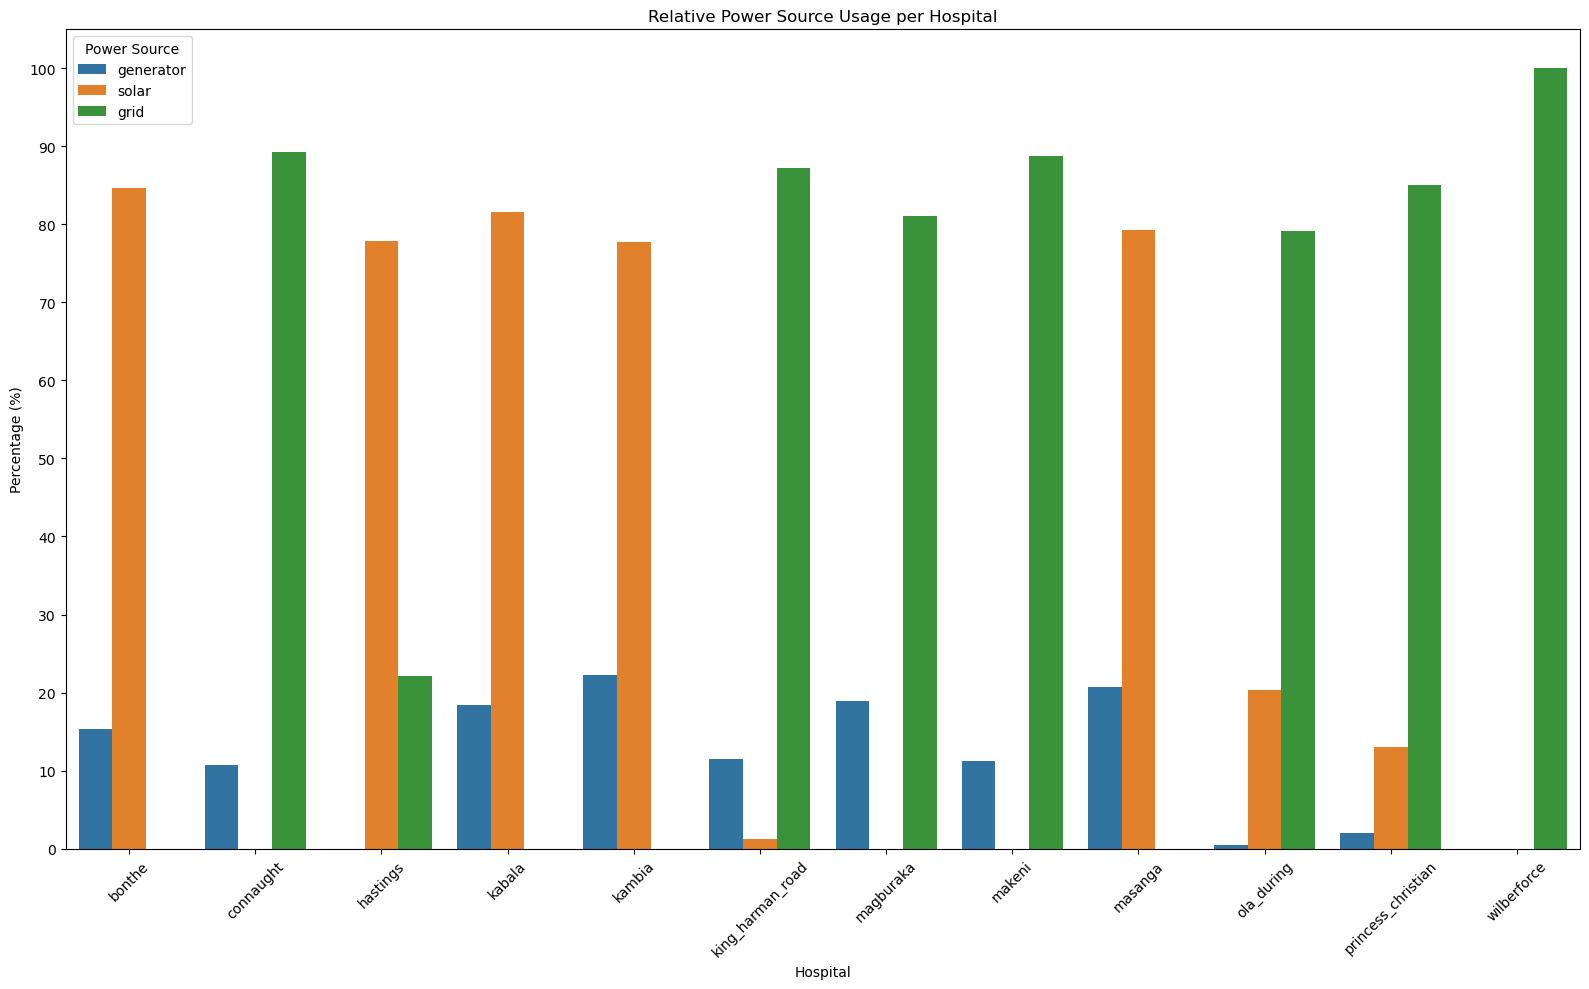

In [152]:

# Compute percentage within each hospital
hospital_dist['percentage'] = hospital_dist.groupby('hospital')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(16, 10))
sns.barplot(data=hospital_dist, x='hospital', y='percentage', hue='power_source_est')
plt.title('Relative Power Source Usage per Hospital')
plt.ylabel('Percentage (%)')
plt.xlabel('Hospital')
plt.xticks(rotation=45)
plt.legend(title='Power Source')
plt.tight_layout()
plt.yticks(range(0, 101, 10))
plt.show()


Things to consider:

- What percentage of a hospital's time is spent using grid, solar, or generator?

- Which hospitals rely more heavily on solar or generator?

## Time based visualisations

- Lets start by adding time-based features

In [ ]:
# Hour of the day (0–23)
clean_df['hour'] = clean_df['time'].dt.hour


In [158]:
#Weekday name 
clean_df['day_of_week'] = clean_df['time'].dt.day_name()  

In [159]:
clean_df['date'] = clean_df['time'].dt.date 

#### Power Source Usage by Hour of Day

In [161]:
hourly_usage = (
    clean_df.groupby(['hour', 'power_source_est'])
    .size()
    .reset_index(name='count')
)


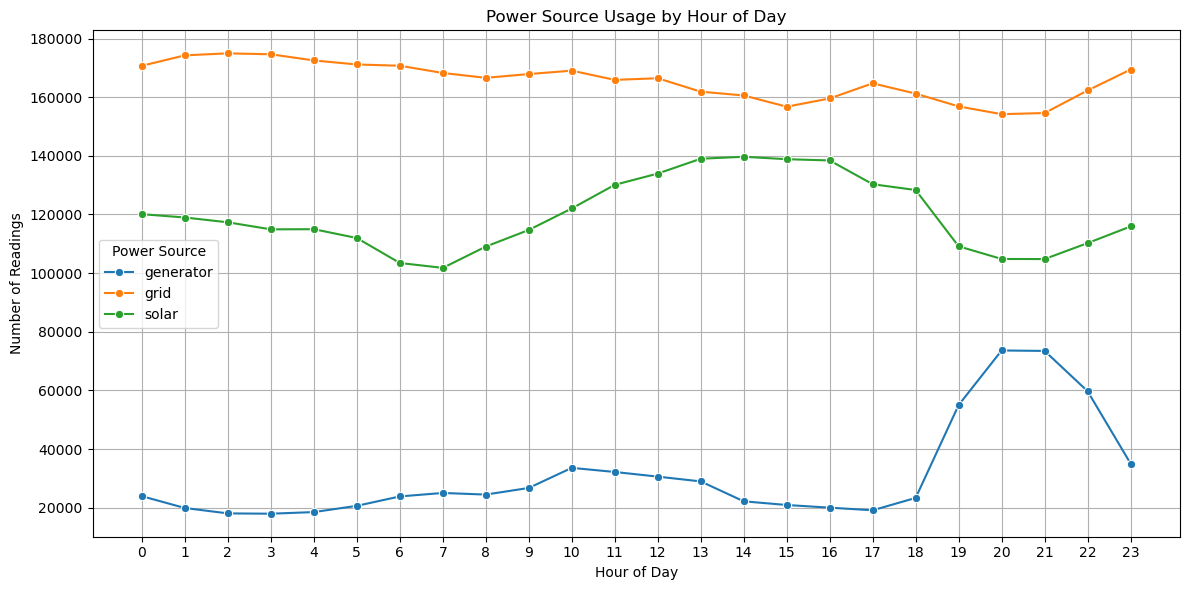

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_usage, x='hour', y='count', hue='power_source_est', marker='o')
plt.title('Power Source Usage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Readings')
plt.xticks(range(0, 24))  
plt.legend(title='Power Source')
plt.grid(True)
plt.tight_layout()
plt.show()

Some things to look for :

Does solar spike in mid-day hours?

Is grid more common at night?

When does generator usage rise?

#### Power Source by room

In [168]:
def plot_power_source_by_room(hospital_name):
    # Filter for selected hospital
    df_hosp = clean_df[clean_df['hospital'] == hospital_name]
    
    # Group by room and power source
    room_usage = (
        df_hosp.groupby(['room', 'power_source_est'])
        .size()
        .reset_index(name='count')
    )
    
    # Plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=room_usage, x='room', y='count', hue='power_source_est')
    plt.title(f'Power Source Usage per Room - {hospital_name.title()} Hospital')
    plt.xlabel('Room')
    plt.ylabel('Number of Readings')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Power Source')
    plt.tight_layout()
    plt.show()

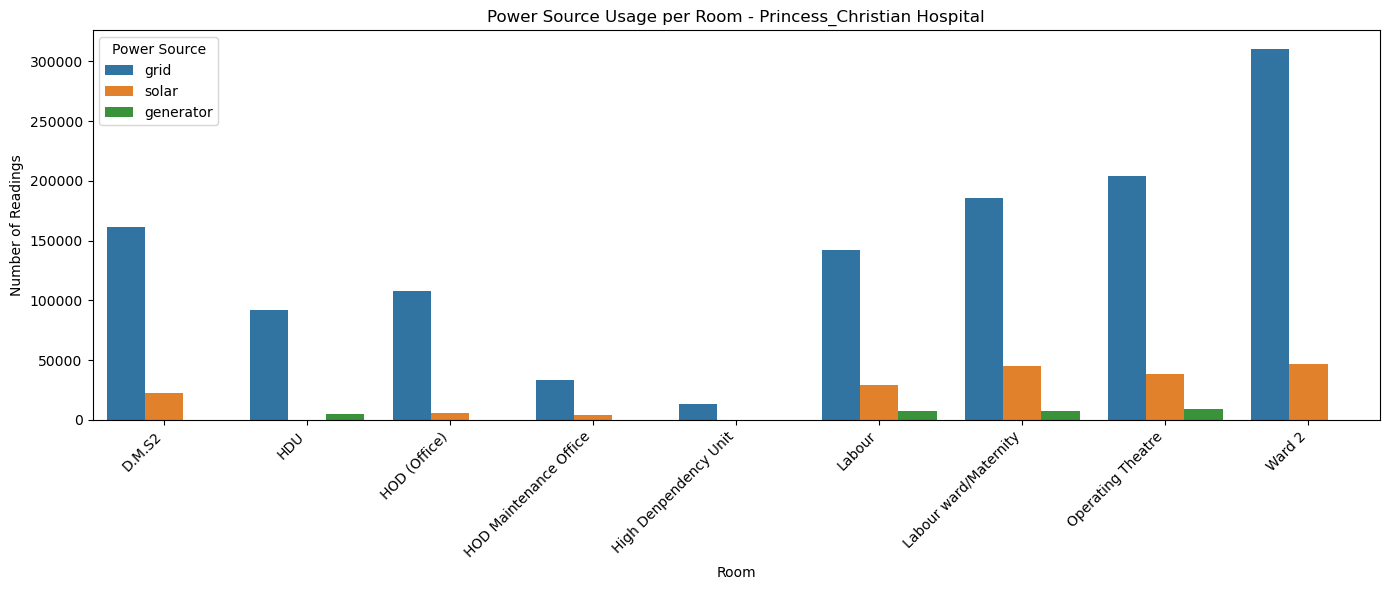

In [170]:
plot_power_source_by_room(hospital_name="princess_christian")

- Which rooms rely most on a particular power source?	
- Do critical rooms (e.g., theatres, ICUs) use backup power (solar/generator) more?
- Are there rooms that rely only on one power source?	

#### Power Source Usage Heatmap (by Day + Hour)

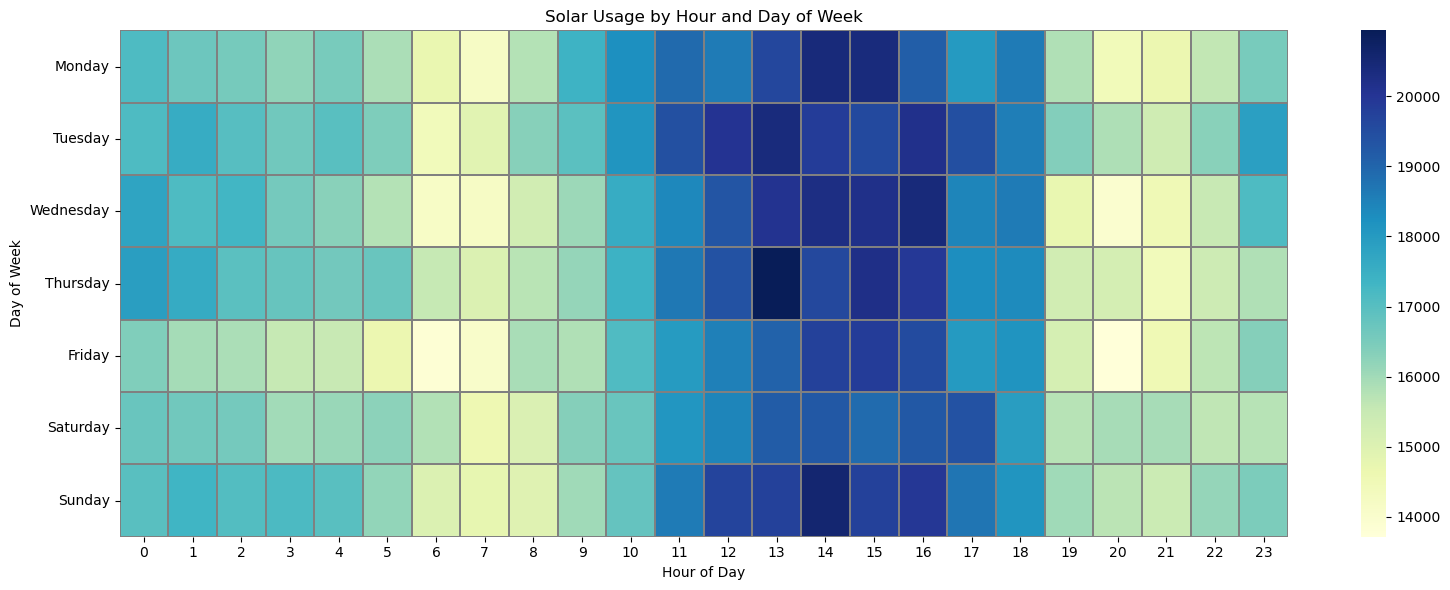

In [189]:
# Choose a power source- you can change the source to view the hit map
source = 'solar'

# Filter dataset
df_source = clean_df[clean_df['power_source_est'] == source]

# Group by day of week and hour
usage_matrix = (
    df_source.groupby(['day_of_week', 'hour'])
    .size()
    .reset_index(name='count')
)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
usage_matrix['day_of_week'] = pd.Categorical(usage_matrix['day_of_week'], categories=day_order, ordered=True)

heatmap_data = usage_matrix.pivot(index='day_of_week', columns='hour', values='count').fillna(0)

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.2, linecolor='gray')
plt.title(f'{source.title()} Usage by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



When solar is most active (likely mid-day)

If generator use spikes at night or weekends

Grid outages or load shedding patterns

In [186]:
def plot_rolling_usage(source, hospital=None, window_size=30):
    """
    Plots the rolling average time series of power source usage.
    
    Parameters:
    - source: str, e.g., 'solar', 'grid', 'generator'
    - hospital: str or None — filter by hospital if provided
    - window_size: int — size of the rolling window (default 30 = ~1 hour)
    """
    
    # Filter by power source
    df_filtered = clean_df[clean_df['power_source_est'] == source]
    
    # Optional: filter by hospital
    if hospital:
        df_filtered = df_filtered[df_filtered['hospital'] == hospital]
    
    # Group by time
    usage = df_filtered.groupby('time').size().reset_index(name='count')
    
    # Rolling average
    usage['rolling_avg'] = usage['count'].rolling(window=window_size, center=True).mean()
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(usage['time'], usage['count'], alpha=0.3, label='Raw Count')
    plt.plot(usage['time'], usage['rolling_avg'], color='orange', label=f'Rolling Avg ({window_size * 2} mins)')
    
    title = f"{source.title()} Usage Over Time"
    if hospital:
        title += f" - {hospital.title()}"
    plt.title(title)
    
    plt.xlabel('Time')
    plt.ylabel('Number of Readings')
    plt.legend()
    plt.tight_layout()
    plt.show()


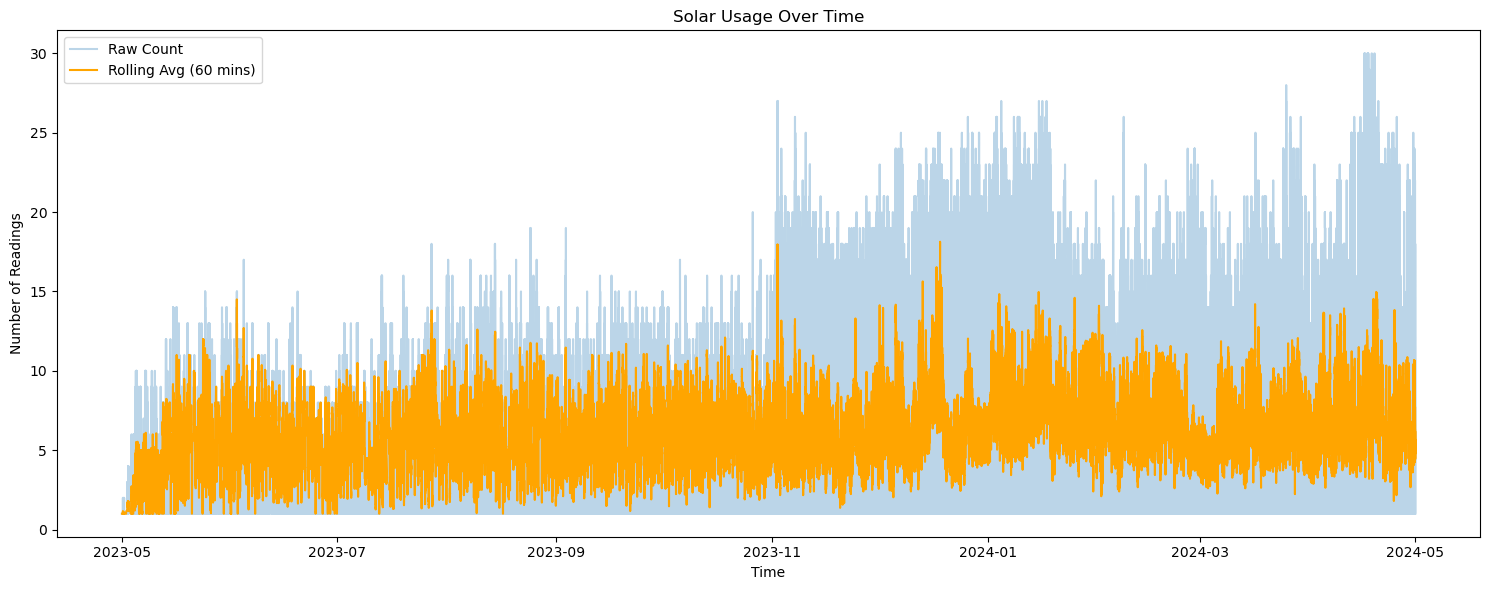

In [187]:
# Solar usage across all hospitals
plot_rolling_usage('solar')

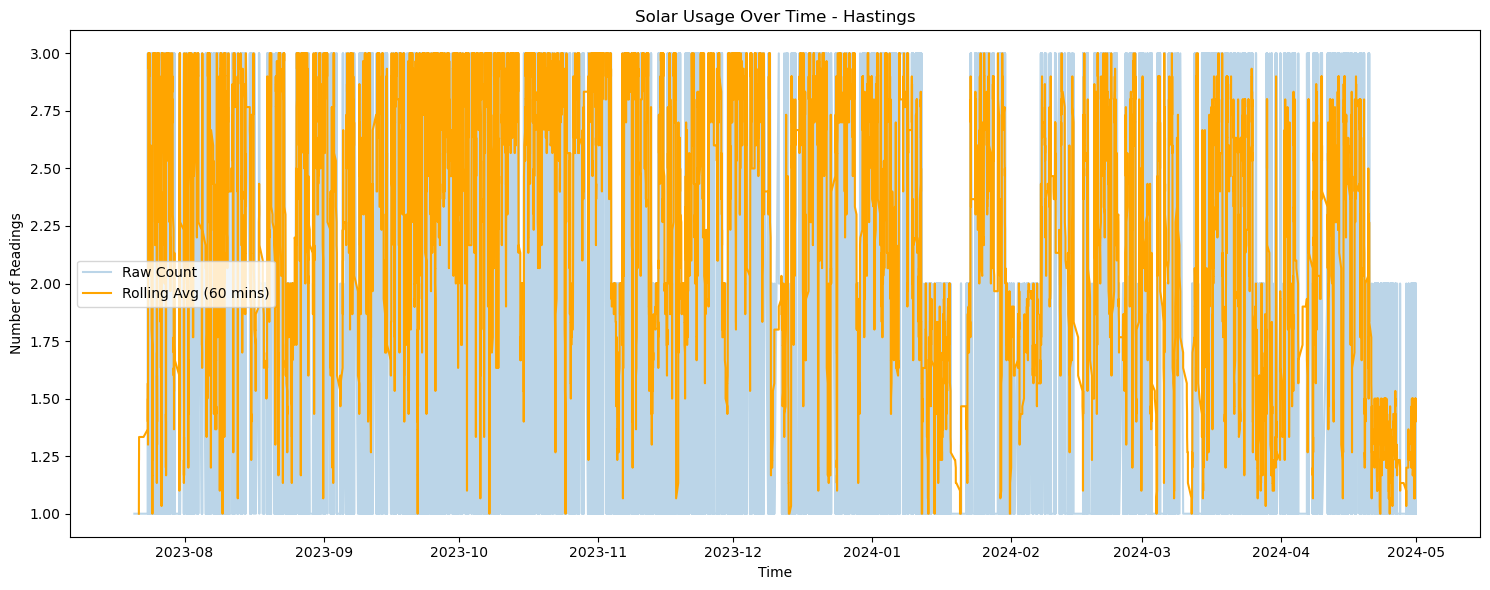

In [188]:
# Generator usage at a specific hospital
plot_rolling_usage(source='solar', hospital='hastings')

#### Voltage and Frequency distributions

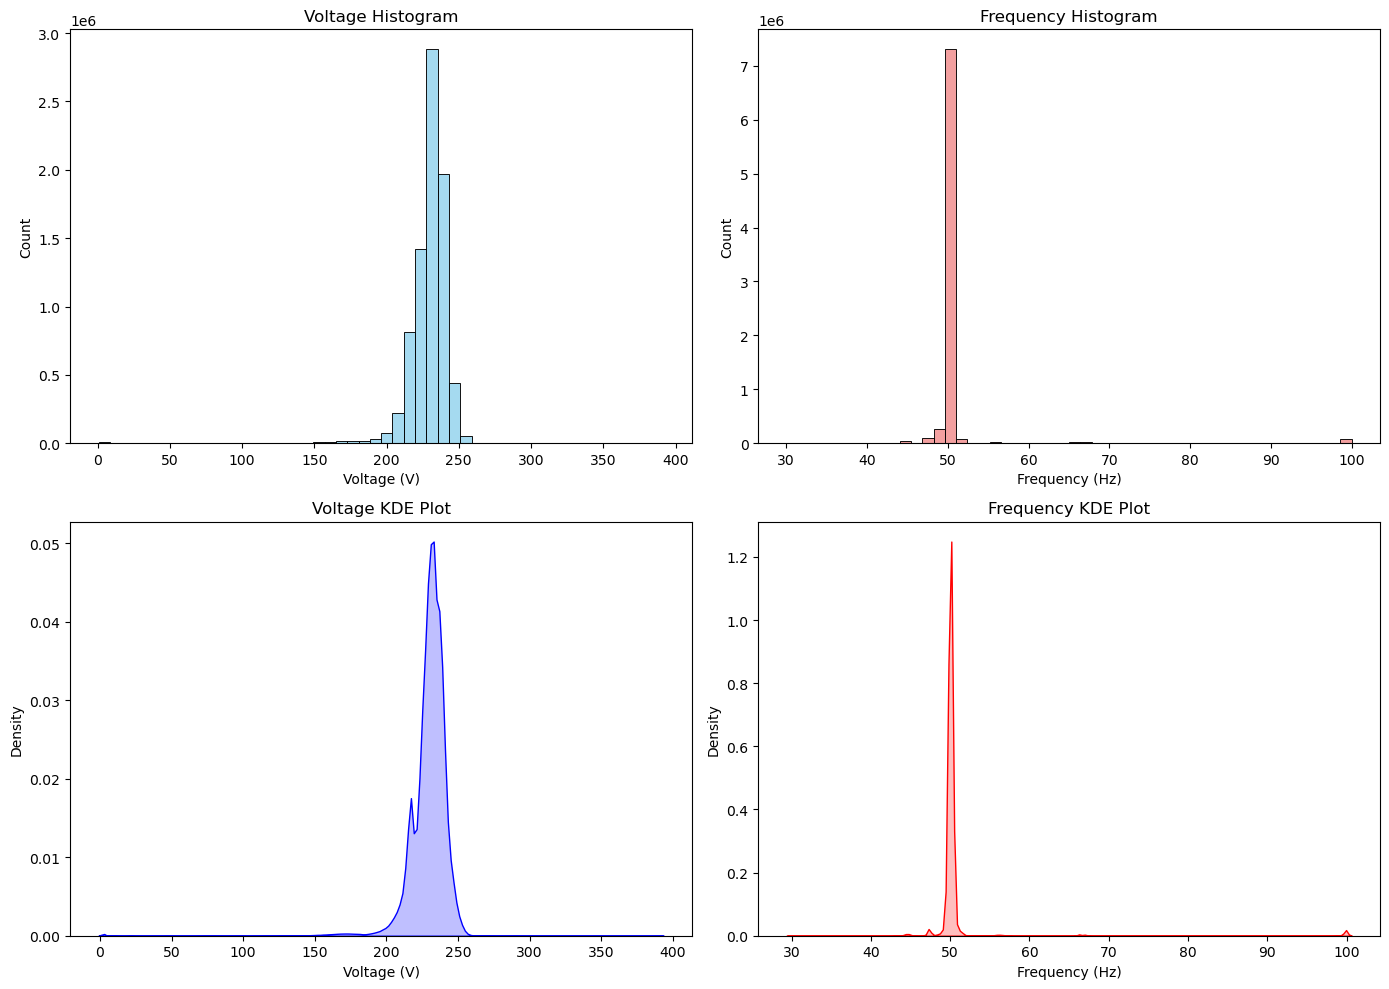

In [194]:

plt.figure(figsize=(14, 10))

# 1. Voltage Histogram
plt.subplot(2, 2, 1)
sns.histplot(clean_df['voltage'], bins=50, kde=False, color='skyblue')
plt.title('Voltage Histogram')
plt.xlabel('Voltage (V)')

# 2. Frequency Histogram
plt.subplot(2, 2, 2)
sns.histplot(clean_df['frequency'], bins=50, kde=False, color='lightcoral')
plt.title('Frequency Histogram')
plt.xlabel('Frequency (Hz)')

# 3. Voltage KDE
plt.subplot(2, 2, 3)
sns.kdeplot(clean_df['voltage'], fill=True, color='blue')
plt.title('Voltage KDE Plot')
plt.xlabel('Voltage (V)')

# 4. Frequency KDE
plt.subplot(2, 2, 4)
sns.kdeplot(clean_df['frequency'], fill=True, color='red')
plt.title('Frequency KDE Plot')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()



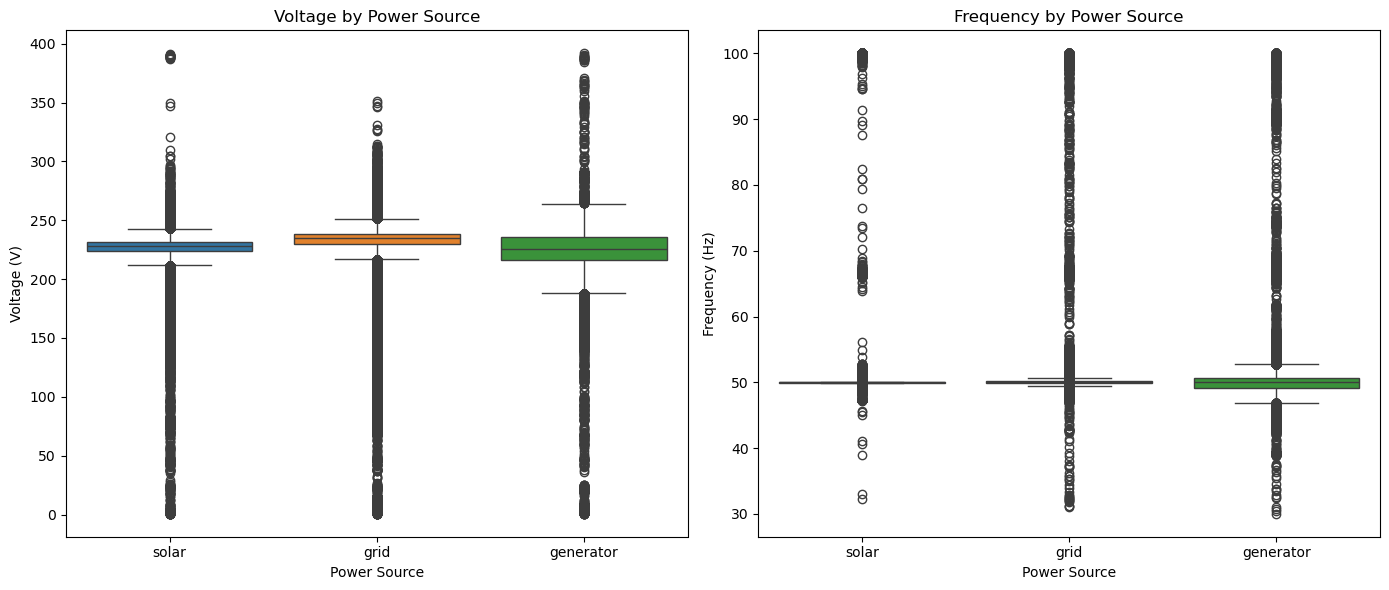

In [199]:
plt.figure(figsize=(14, 6))

# Voltage
plt.subplot(1, 2, 1)
sns.boxplot(data=clean_df, x='power_source_est', y='voltage',hue='power_source_est')
plt.title('Voltage by Power Source')
plt.xlabel('Power Source')
plt.ylabel('Voltage (V)')

# Frequency
plt.subplot(1, 2, 2)
sns.boxplot(data=clean_df, x='power_source_est', y='frequency',hue='power_source_est')
plt.title('Frequency by Power Source')
plt.xlabel('Power Source')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


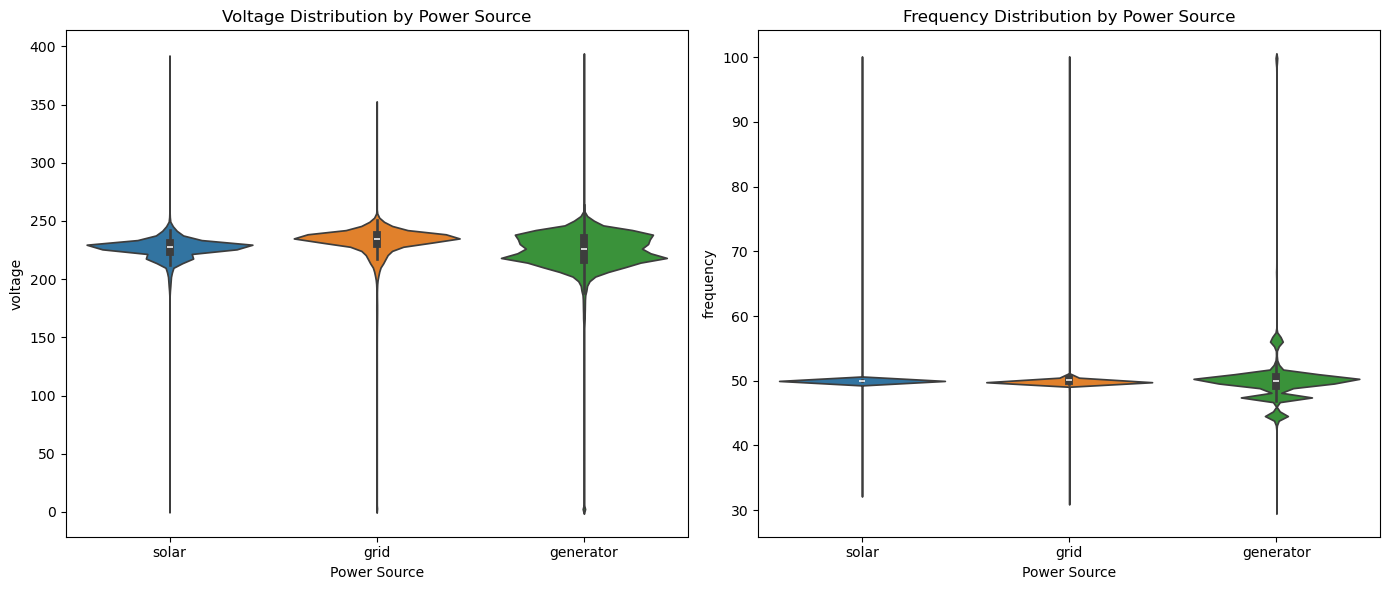

In [201]:
plt.figure(figsize=(14, 6))

# Voltage
plt.subplot(1, 2, 1)
sns.violinplot(data=clean_df, x='power_source_est', y='voltage', hue='power_source_est')
plt.title('Voltage Distribution by Power Source')
plt.xlabel('Power Source')

# Frequency
plt.subplot(1, 2, 2)
sns.violinplot(data=clean_df, x='power_source_est', y='frequency', hue='power_source_est')
plt.title('Frequency Distribution by Power Source')
plt.xlabel('Power Source')

plt.tight_layout()
plt.show()
